In [33]:
"""
Created in 2022

@author: quoc-thong nguyen
"""

'\nCreated in 2022\n\n@author: quoc-thong nguyen\n'

In [9]:
import os
import sys
import numpy as np
import pandas as pd
import datetime, re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
from datetime import time
import time
warnings.filterwarnings("ignore")
%run clustering_function.py
%run distance_functions.py
%run VRPTW.py

In [10]:
path = os.getcwd()
dire = path+'/data/Data_LAD-2.csv'
df = pd.read_csv(dire)
df = df.iloc[:,1:]
df['DATE'] = pd.to_datetime(df['DATE'])
df['FIN CRÉNEAUX'] = pd.to_datetime(df['FIN CRÉNEAUX'])
df['DÉBUT CRÉNEAUX'] = pd.to_datetime(df['DÉBUT CRÉNEAUX'])
# df['TIME WINDOW'] = df['FIN CRÉNEAUX'] - df['DÉBUT CRÉNEAUX']
df['WDAY'] = [val.date().weekday() for val in df['DATE']]
df['begin_time'] = df['DÉBUT CRÉNEAUX'].dt.hour
df['delivered'] = np.nan
df['1/2day'] = 0 # morning
K = 2
if K == 2:
    df['1/2day'][df['begin_time']>14] = 1 #afternoon  11 14
elif K == 3:
    df['1/2day'][df['begin_time']>11] = 1 #afternoon
    df['1/2day'][df['begin_time']>17] = 2 #evening

## cost calculation

In [12]:
#-Le dépôt au code postal 93500 ville de Pantin: 48.900212,2.424839
API = '5b3ce3597851110001cf6248519ed27d3d88420788b9d912eea68259'
DEPOT2 = [2.424839,48.900212]
AVGspeed = 13100/60 #13.1km/h
flag = 0 # 0:space; 1:space-time; 3: time
VEHICLE = 0 # type vehicle 0: van, 1: electric cycling
D = 6 # 6 days, Monday -> Saturday
CostDiesel = np.empty([D, K]); CostElectric = np.empty([D, K])
Ntour = np.empty([D, K]); Nclient = np.empty([D, K])
Distance = np.empty([D, K]); Time_ = np.empty([D, K])
request_count = 0
DIF = []
NbacTour = []
TpRoute = []; DpRoute = []; CusProute = []
TcostHd = TcostKd = 0; TcostHe = TcostKe = 0
ServiceTime = 6 #minutes
# Data preparation
Nbac = 75 # max number of BACS per vehicle
m = 2; BacPclus = m*Nbac # N de BAC de chaque cluster
max_client = 49 # N clients de chaque cluster

# starting time
start = time.time()
#------------------------------------------------
for d in range(1): # day in week 0->5
    if d == 5: AVGspeed = 14700/60
    for hday in range(1): # 0: morning, 1: afternoon, 2: evening
        NbacTouri = []
        CLIENTSi = df[(df['WDAY'] == d) & (df['1/2day'] == hday)][['ID','LATITUDE','LONGITUDE',
                                                           'DÉBUT CRÉNEAUX','FIN CRÉNEAUX',
                                                           '# BACS','begin_time','delivered']]
        CLIENTSi['CLUSTER'] = 0
        #-Clustering the clients with size constraints-
        if CLIENTSi['# BACS'].sum()>BacPclus:
            CLIENTSi, sum_clus, centers = Clustering_constraint(CLIENTSi, BacPclus, flag) # by BACS
        Nclient[d][hday] = len(CLIENTSi)


        CostD = CostE = Nv = dist = TotalTime = 0
        print('\n day: {}'.format(d),'timeframe: {}'.format(hday))
        for c in CLIENTSi['CLUSTER'].unique()[0:1]:
            if request_count == 40:
                request_count = 0
                time.sleep(60)
            request_count += 1
            CLUSk = CLIENTSi[CLIENTSi['CLUSTER'] == c]
            CLUSk = CLUSk.reset_index(drop=True)
            CLUSk.index += 1
            # COORk array of Geo coodinates
            COORk2 = CLUSk[['LONGITUDE','LATITUDE']]
            COORk2 = COORk2.values.tolist()
            COORk2.insert(0,DEPOT2)
#             time window
            w = .75 # presented at the depot before the first command, 45m for van, 30m for bike and ADV
            startH = min(CLUSk['DÉBUT CRÉNEAUX'].dt.hour) - w
            endH = startH + 5

            c_TIME = 60
            TIME_start = c_TIME*startH
#             ----
#             CLUSk['start'] = c_TIME*CLUSk['DÉBUT CRÉNEAUX'].dt.hour-TIME_start; EARLY = 0 # strict TW
            CLUSk['begin_time'] = c_TIME*CLUSk['DÉBUT CRÉNEAUX'].dt.hour - TIME_start
            CLUSk['start'] = c_TIME*(startH+w) - TIME_start; EARLY = 1 # can be early
#             ----
            CLUSk['end'] = c_TIME*CLUSk['FIN CRÉNEAUX'].dt.hour-TIME_start

            t_depot = (0,c_TIME*(endH-startH))
            TW = list(CLUSk[['start','end']].to_records(index = False))
            TW.insert(0,t_depot); test = [tuple(map(int,x)) for x in TW]
            TW = test
            # request distance_time matrices from open_route_service
            Response = send_request(COORk2, VEHICLE, API)
            # distance matrix
            D = np.array(Response['distances'])
            # compute time matrix
#             T_round = np.asmatrix(np.round(np.array(Response['durations'])/60))
            T_round = np.asmatrix(np.round(D/AVGspeed))
            T_round[1:,1:] += ServiceTime
            for i in range(len(T_round)):
                T_round[i,i] = 0
            T_round = np.asarray(T_round)
            T_round = [list(map(int,x)) for x in T_round]
            BacLim = list(CLUSk['# BACS'])
            BacLim.insert(0,0)
            # create data to solve VRP with TW
            data = create_data_modelTW()
            data['demands'] = BacLim
            data['time_matrix'] = T_round
            data['time_windows'] = TW
            data['num_vehicles'] = int(np.ceil(CLUSk['# BACS'].sum()/Nbac))+7
            data['depot'] = 0
            data['vehicle_capacities'] = list(np.ones(data['num_vehicles'], dtype=int)*Nbac)

            route, TIME, total_time, time_p_route, Nveh = SolveProblemTW(data)

            for x in route:
                NbacTouri.append(CLUSk.loc[[num for num in x if num != 0]]['# BACS'].sum())
                CusProute.append(len(CLUSk.loc[[num for num in x if num != 0]]))
            CusProute = [n for n in CusProute if n != 0]
            NbacTouri = [n for n in NbacTouri if n != 0]
            TpRoute += [(Tr+ServiceTime) for Tr in time_p_route]
            total_time = (total_time + ServiceTime*Nveh)/60
#             print(max(route,key = len))
            Nv += Nveh
            total_dist, Dtour = route_distance(route, D)
            total_dist /= 1000
            DpRoute += Dtour

            TotalTime += total_time
            dist += total_dist
#             print('N vans: {}'.format(Nveh))
#             print('Total time: {} h'.format(total_time))
#             print('total distance : {} km'.format(total_dist))

            costHd = 21.11; costKd = .48 # diesel
            costHe = 22.77; costKe = .245 # electrique

            TcostHd += total_time*costHd; TcostKd += total_dist*costKd
            TcostHe += total_time*costHe; TcostKe += total_dist*costKe
            CostD += total_time*costHd + total_dist*costKd
            CostE += total_time*costHe + total_dist*costKe

            # compute how early the delivery
            if EARLY == 1:
                l = (set([tuple(l) for l in route]));t = tuple()
                for j in l:t+=j
                r = [i for i in list(t) if i != 0]
                t = [i for i in TIME if i != (0,0)]
                for i in range(len(t)):
                    CLUSk['delivered'].iloc[r[i]-1] = float(t[i][0])
                DIF += list(CLUSk['begin_time']-CLUSk['delivered'])
            # -------------------------------
        NbacTour.append(NbacTouri)
        CostDiesel[d][hday] = CostD
        CostElectric[d][hday] = CostE
        Ntour[d][hday] = Nv
        Distance[d][hday] = dist
        Time_[d][hday] = TotalTime
# end time
end = time.time()
# time taken
print(f"Runtime of the program is {end - start}")
#-------------------------------------------
DIF = list(filter(lambda x: (x > 0), DIF))
print('mean early: ',np.mean(DIF)/60, 'and std: ',np.std(DIF)/60)

print('mean time/tour: ',np.mean(TpRoute)/60, 'and std time/tour: ',np.std(TpRoute)/60)
# cost per tour
DpRoute = list(filter(lambda x: (x > 0), DpRoute))
CostTourKd = [costKd*dt/1000 for dt in DpRoute]; CostTourHd = [costHd*dt/60 for dt in TpRoute]
CostTourKe = [costKe*dt/1000 for dt in DpRoute]; CostTourHe = [costHe*dt/60 for dt in TpRoute]
CostTourD = [sum(x) for x in zip(CostTourKd, CostTourHd)]
CostTourE = [sum(x) for x in zip(CostTourKe, CostTourHe)]

print('\n mean cost/tour D: ',np.mean(CostTourD), 'and std D: ',np.std(CostTourD))
print('\n mean cost/tour E: ',np.mean(CostTourE), 'and std E: ',np.std(CostTourE))



 day: 0 timeframe: 0
Solver status:  1
Runtime of the program is 114.08416080474854
mean early:  3.0344444444444445 and std:  1.648135497246495
mean time/tour:  3.9166666666666665 and std time/tour:  0.6333333333333333

 mean cost/tour D:  95.19689813333333 and std D:  15.276497866666674

 mean cost/tour E:  95.570908075 and std E:  15.394278425000003


In [ ]:
print('mean dist: ',np.mean(DpRoute)/1000, 'and std dist: ',np.std(DpRoute)/1000)
print('mean client: ',np.mean(CusProute), 'and std client: ',np.std(CusProute))

In [ ]:
print('total distance',Distance.sum())
print('total tour',Ntour.sum())
print('total time',Time_.sum())

### ---------------
cost = CostDiesel.sum();print("COST DIESEL {:.1f}".format(cost))
costH = TcostHd; costK = TcostKd
print("{:.2f}%".format(100*costH/cost))

cost = CostElectric.sum();print("COST ELECTRIC {:.1f}".format(cost))
costH = TcostHe; costK = TcostKe
print("{:.2f}".format(100*costH/cost))

## Example VRP

In [ ]:
# load data

df = pd.read_csv("data/LAD2.csv", index_col=0)
df['1/2day'] = 0 # morning
K = 2
if K == 2:
    df['1/2day'][df['begin_time']>14] = 1 #afternoon  11 14
elif K == 3:
    df['1/2day'][df['begin_time']>11] = 1 #afternoon
    df['1/2day'][df['begin_time']>17] = 2 #evening
df.DATE = pd.to_datetime(df.DATE)
df['DÉBUT CRÉNEAUX'] = pd.to_datetime(df['DÉBUT CRÉNEAUX'])
df['FIN CRÉNEAUX'] = pd.to_datetime(df['FIN CRÉNEAUX'])

In [ ]:
#-Le dépôt au code postal 93500 ville de Pantin: 48.900212,2.424839

API = '5b3ce3597851110001cf6248519ed27d3d88420788b9d912eea68259'

DEPOT2 = [2.424839,48.900212]
AVGspeed = 13100/60 #13.1km/h
flag = 0 # 0:space; 1:space-time; 3: time
VEHICLE = 0 # type vehicle 0: van, 1: electric cycling
request_count = 0

ServiceTime = 6 #minutes
# Data preparation
Nbac = 75 # max number of BACS per vehicle
m = 2; BacPclus = m*Nbac # N de BAC de chaque cluster


d=0; hday = 1
#------------------------------------------------

CLIENTSi = df[(df['WDAY'] == d) & (df['1/2day'] == hday)][['ID','LATITUDE','LONGITUDE',
                                                    'DÉBUT CRÉNEAUX','FIN CRÉNEAUX',
                                                    '# BACS','begin_time','delivered']]
CLIENTSi['CLUSTER'] = 0
#-Clustering the clients with size constraints-
if CLIENTSi['# BACS'].sum()>BacPclus:
    CLIENTSi, sum_clus, centers = Clustering_constraint(CLIENTSi, BacPclus, flag) # by BACS

print('\n day: {}'.format(d),'timeframe: {}'.format(hday))
for c in CLIENTSi['CLUSTER'].unique()[0:1]:
    if request_count == 40:
        request_count = 0
        time.sleep(60)
    request_count += 1
    CLUSk = CLIENTSi[CLIENTSi['CLUSTER'] == c]
    CLUSk = CLUSk.reset_index(drop=True)
    CLUSk.index += 1
    # COORk array of Geo coodinates
    COORk2 = CLUSk[['LONGITUDE','LATITUDE']]
    COORk2 = COORk2.values.tolist()
    COORk2.insert(0,DEPOT2)
#             time window
    w = .75 # presented at the depot before the first command, 45m for van, 30m for bike and ADV
    startH = min(CLUSk['DÉBUT CRÉNEAUX'].dt.hour) - w
    endH = startH + 5

    c_TIME = 60
    TIME_start = c_TIME*startH
#             ----
    CLUSk['begin_time'] = c_TIME*CLUSk['DÉBUT CRÉNEAUX'].dt.hour - TIME_start
    CLUSk['start'] = c_TIME*(startH+w) - TIME_start; EARLY = 1 # can be early
#             ----
    CLUSk['end'] = c_TIME*CLUSk['FIN CRÉNEAUX'].dt.hour-TIME_start

    t_depot = (0,c_TIME*(endH-startH))
    TW = list(CLUSk[['start','end']].to_records(index = False))
    TW.insert(0,t_depot); test = [tuple(map(int,x)) for x in TW]
    TW = test
    # request distance_time matrices from open_route_service
    Response = send_request(COORk2, VEHICLE, API)
    # distance matrix
    D = np.array(Response['distances'])
    T_round = np.asmatrix(np.round(D/AVGspeed))
    T_round[1:,1:] += ServiceTime
    for i in range(len(T_round)):
        T_round[i,i] = 0
    T_round = np.asarray(T_round)
    T_round = [list(map(int,x)) for x in T_round]
    BacLim = list(CLUSk['# BACS'])
    BacLim.insert(0,0)
    # create data to solve VRP with TW
    data = create_data_modelTW()
    data['demands'] = BacLim
    data['time_matrix'] = T_round
    data['time_windows'] = TW
    data['num_vehicles'] = int(np.ceil(CLUSk['# BACS'].sum()/Nbac))+7
    data['depot'] = 0
    data['vehicle_capacities'] = list(np.ones(data['num_vehicles'], dtype=int)*Nbac)

    route, TIME, total_time, time_p_route, Nveh = SolveProblemTW(data)


 day: 0 timeframe: 1
Solver status:  1


In [ ]:
route
from operator import itemgetter
itemgetter(*route[0])(COORk2)

([2.424839, 48.900212],
 [2.399559, 48.88836],
 [2.396007, 48.886249],
 [2.405423, 48.881512],
 [2.401933, 48.879643],
 [2.396753, 48.87869],
 [2.397697, 48.87888],
 [2.400099, 48.877182],
 [2.403894, 48.875709],
 [2.406232, 48.873248],
 [2.397868, 48.87061],
 [2.397014, 48.87064],
 [2.399424, 48.872752],
 [2.408111, 48.872509],
 [2.408696, 48.873201],
 [2.407779, 48.877158],
 [2.408228, 48.880489])

### ------ Visuallize locations on map -------

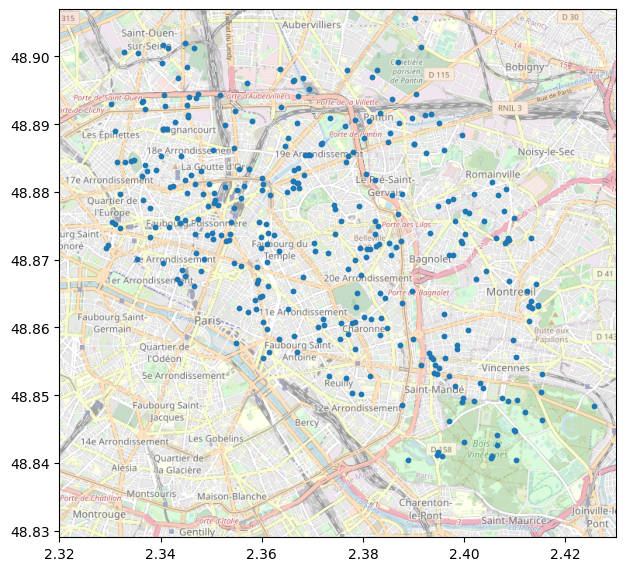

In [ ]:
# ALL LOCATIONS
dfCOOR = df[['LATITUDE','LONGITUDE']]
BBox = (2.32,2.43,48.829, 48.907)
ruh_m = plt.imread('data/map.png')
px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(figsize = (718*px, 686*px))
ax.scatter(dfCOOR.LONGITUDE, dfCOOR.LATITUDE, alpha= 1,
           cmap = 'cividis', s=10)
# ax.set_title('Client Data on Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0,alpha=.69, extent = BBox, aspect= 'auto')
# plt.savefig("map.eps", bbox_inches='tight', format='eps')